In [ ]:
!pip install xgboost

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [ ]:
from google.colab import files
uploaded = files.upload()
print(uploaded)

Saving mock_kaggle (2).csv to mock_kaggle (2) (1).csv
{'mock_kaggle (2) (1).csv': b'data,venda,estoque,preco\n2014-01-01,0,4972,1.29\n2014-01-02,70,4902,1.29\n2014-01-03,59,4843,1.29\n2014-01-04,93,4750,1.29\n2014-01-05,96,4654,1.29\n2014-01-06,145,4509,1.29\n2014-01-07,179,4329,1.29\n2014-01-08,321,4104,1.29\n2014-01-09,125,4459,1.09\n2014-01-10,88,5043,1.09\n2014-01-11,188,5239,1.09\n2014-01-12,121,5118,1.09\n2014-01-13,134,4984,1.09\n2014-01-14,80,4904,1.09\n2014-01-15,82,4822,1.09\n2014-01-16,94,4728,1.19\n2014-01-18,159,4464,1.19\n2014-01-19,199,4265,1.19\n2014-01-20,104,4161,1.19\n2014-01-21,70,4091,1.19\n2014-01-22,127,3964,1.09\n2014-01-23,96,3868,1.09\n2014-01-24,75,3793,1.09\n2014-01-25,198,3595,1.09\n2014-01-26,168,3427,1.09\n2014-01-27,125,3302,1.09\n2014-01-28,86,3216,1.09\n2014-01-29,222,2994,0.99\n2014-01-30,272,2723,0.99\n2014-01-31,209,2514,0.99\n2014-02-01,369,2145,0.99\n2014-02-02,217,1928,0.99\n2014-02-03,97,1831,0.99\n2014-02-04,117,1714,0.99\n2014-02-05,100,1998,1

In [ ]:
df = pd.read_csv('mock_kaggle (2).csv')

In [ ]:
df.head()

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [ ]:
df.tail()


,data,venda,estoque,preco
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39
936,2016-07-31,183,3642,2.39


In [ ]:
# df = df.set_index('data') # This line is commented out as 'data' is already the index

In [ ]:
# Check the column names in the dataframe
print(df.columns)

# If the 'data' column has extra spaces or different casing, we can clean up the column names
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces

# Check again
print(df.columns)

# Now try converting the 'data' column to datetime
if 'data' in df.columns:
    df['data'] = pd.to_datetime(df['data'])
    print(df['data'].dtype)  # Verify the conversion
else:
    print("Column 'data' is missing or has a different name.")


Index(['data', 'venda', 'estoque', 'preco'], dtype='object')
Index(['data', 'venda', 'estoque', 'preco'], dtype='object')
datetime64[ns]


In [ ]:
# Check the column names of your DataFrame
print(df.columns)


Index(['data', 'venda', 'estoque', 'preco'], dtype='object')


In [ ]:
# Print the column names to inspect them
print(df.columns)

# The 'data' column is already set as the index and is in datetime format.
# The following lines are unnecessary and were causing the error.
# df.set_index('Data', inplace=True)
# df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
# df.set_index('Data', inplace=True)

Index(['data', 'venda', 'estoque', 'preco'], dtype='object')


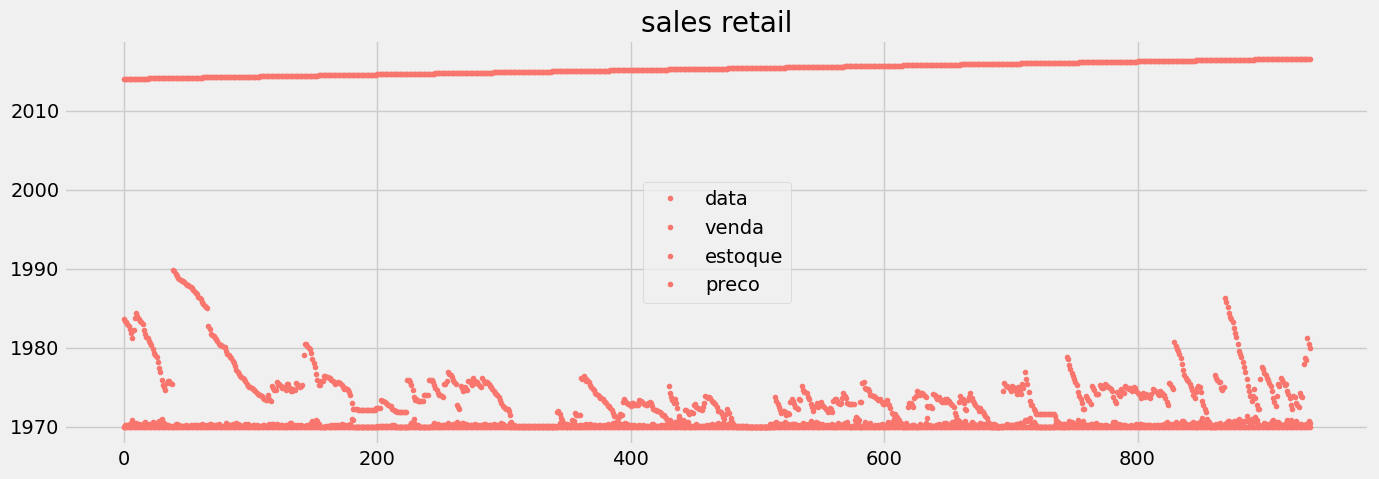

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0], title='sales retail')

In [ ]:
split_date = '2015-04-04' # Use a consistent date format
venda_train = df.loc[df.index <= split_date].copy()
venda_test = df.loc[df.index > split_date].copy()

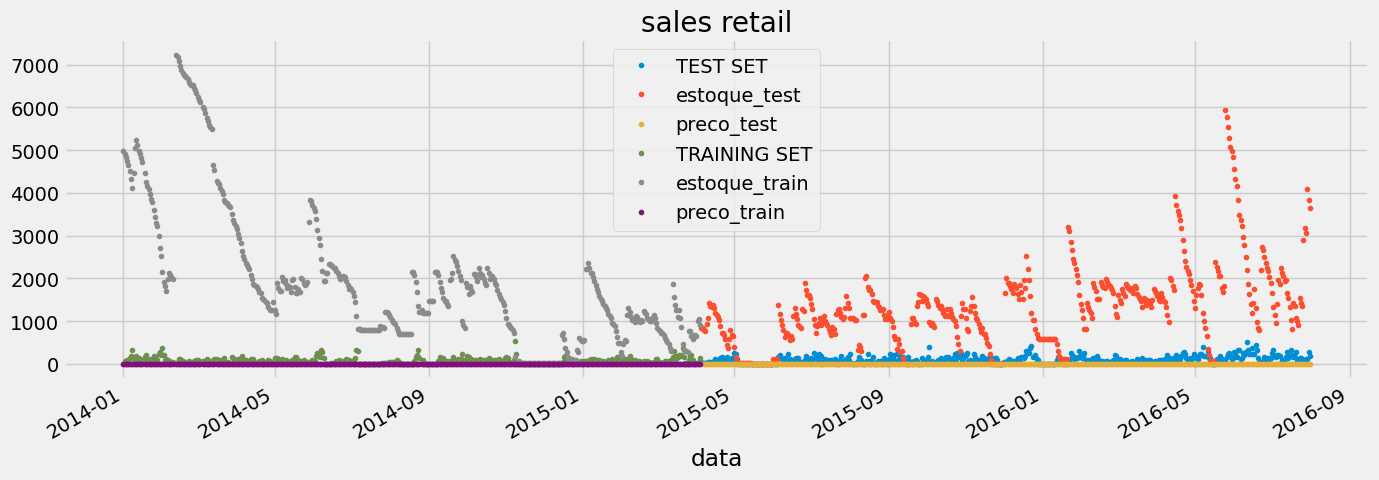

In [ ]:
_ = venda_test \
    .rename(columns={'venda': 'TEST SET'}) \
    .join(venda_train.rename(columns={'venda': 'TRAINING SET'}), how='outer', lsuffix='_test', rsuffix='_train') \
    .plot(figsize=(15,5), title='sales retail', style='.')

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    # Ensure the index is a datetime index
    df.index = pd.to_datetime(df.index)
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day

    # Return the DataFrame with the new features
    if label:
        y = df[label]
        return df, y
    return df

In [ ]:
X_train, y_train = create_features(venda_train, label='venda')
X_test, y_test = create_features(venda_test, label='venda')

In [ ]:
print(venda_train.columns)
print(venda_test.columns)

Index(['venda', 'estoque', 'preco', 'date', 'hour', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'dayofmonth'],
      dtype='object')
Index(['venda', 'estoque', 'preco', 'date', 'hour', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'dayofmonth'],
      dtype='object')


In [ ]:
import xgboost as xgb
print(xgb.__version__)


3.0.4


In [ ]:
pip install --upgrade xgboost


In [ ]:
X_train, y_train = create_features(venda_train, label='venda')
X_test, y_test = create_features(venda_test, label='venda')

RMSE: 8.442767724109299
R2 Score: 0.9904229640960693


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

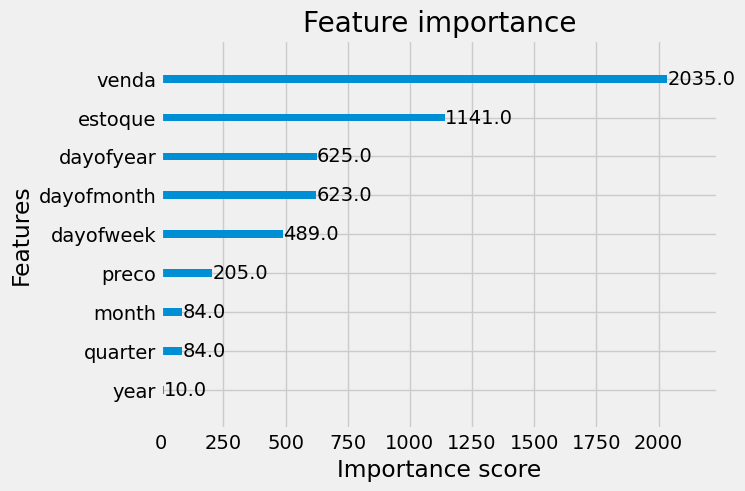

In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the regressor
reg = xgb.XGBRegressor(n_estimators=1000)

# Fit the model
reg.fit(X_train, y_train,
        verbose=True)

# Drop the extra columns from X_test
X_test = X_test.drop(['sales_Prediction', 'error', 'abs_error'], axis=1, errors='ignore')

# Make predictions on the test set
y_pred = reg.predict(X_test)

# Evaluate the model
# Calculate RMSE and R² score for evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

# Visualize feature importance
xgb.plot_importance(reg)

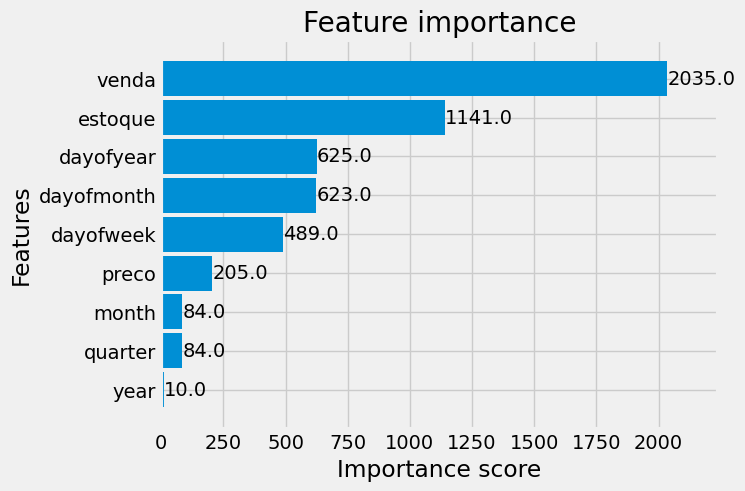

In [ ]:
_ = plot_importance(reg, height=0.9)

In [ ]:
venda_test['sales_Prediction'] = reg.predict(X_test)
venda_all = pd.concat([venda_test, venda_train], sort=False)

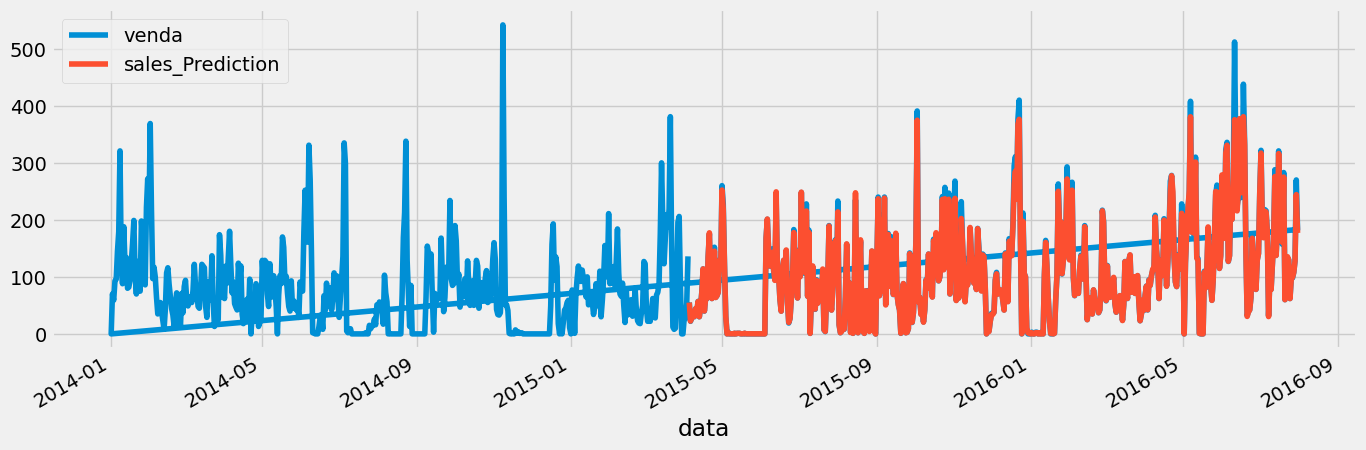

In [ ]:
_ = venda_all[['venda','sales_Prediction']].plot(figsize=(15, 5))

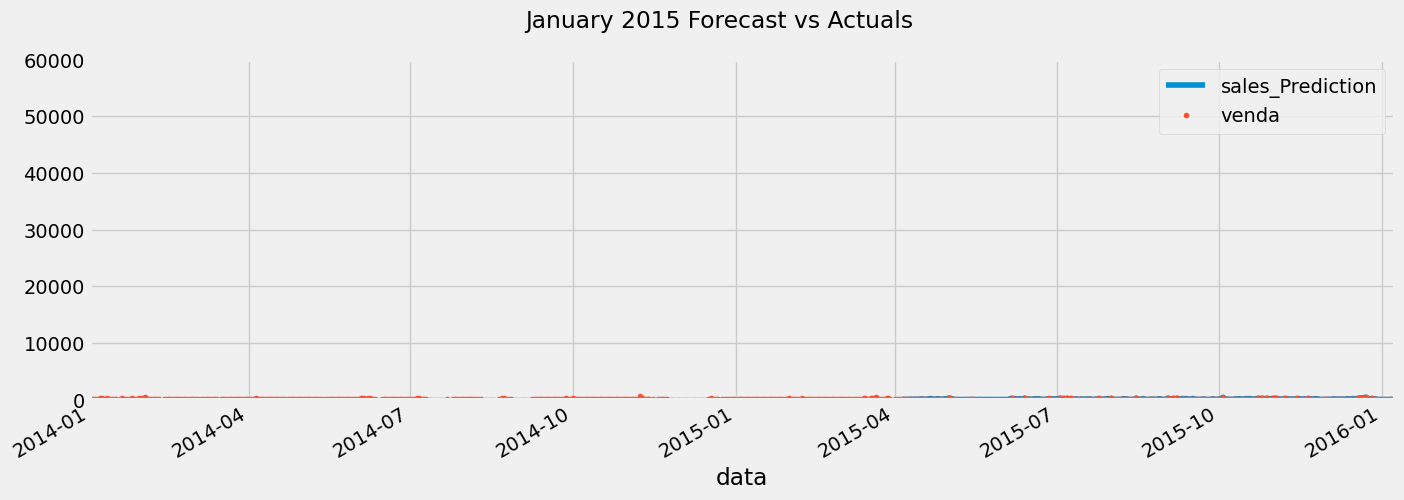

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = venda_all[['sales_Prediction','venda']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2014', upper='01-08-2016')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [ ]:
from sklearn.metrics import mean_squared_error

# Ensure venda_test has the 'sales_Prediction' column
# This assumes that the 'reg' model and X_test are already defined from previous steps.
if 'sales_Prediction' not in venda_test.columns:
    venda_test['sales_Prediction'] = reg.predict(X_test)

mean_squared_error(y_true=venda_test['venda'],
                   y_pred=venda_test['sales_Prediction'])

71.28032684326172

In [ ]:
mean_absolute_error(y_true=venda_test['venda'],
                y_pred=venda_test['sales_Prediction'])

2.505375862121582

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_true=venda_test['venda'],
                   y_pred=venda_test['sales_Prediction'])

/tmp/ipython-input-1542411197.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


np.float64(inf)

In [ ]:
venda_test['error'] = venda_test['venda'] - venda_test['sales_Prediction']
venda_test['abs_error'] = venda_test['error'].apply(np.abs)

# Apply create_features to add 'year', 'month', 'dayofmonth' columns to venda_test
venda_test_features = create_features(venda_test.copy())

error_by_day = venda_test_features.groupby(['year','month','dayofmonth']) \
    .mean()[['venda','sales_Prediction','error','abs_error']]

In [ ]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

venda  sales_Prediction      error  abs_error
year month dayofmonth                                               
2016 6     2           235.0        251.071182 -16.071182  16.071182
     4     23          234.0        249.460083 -15.460083  15.460083
2015 8     15          235.0        247.497025 -12.497025  12.497025
     6     13          237.0        249.166382 -12.166382  12.166382
2016 6     14          239.0        249.511459 -10.511459  10.511459
           16          239.0        247.874985  -8.874985   8.874985
     5     6           243.0        251.194336  -8.194336   8.194336
     6     1           273.0        278.802032  -5.802032   5.802032
     5     27          244.0        249.742020  -5.742020   5.742020
     6     17          243.0        247.924896  -4.924896   4.924896

In [ ]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

venda  sales_Prediction       error   abs_error
year month dayofmonth                                                 
2016 6     11          512.0        375.722717  136.277283  136.277283
           18          438.0        380.965088   57.034912   57.034912
2015 12    23          410.0        376.400635   33.599365   33.599365
           19          295.0        262.613525   32.386475   32.386475
     11    2           268.0        237.674316   30.325684   30.325684
           7           232.0        202.400665   29.599335   29.599335
2016 5     7           408.0        380.829956   27.170044   27.170044
     7     30          270.0        244.297684   25.702316   25.702316
2015 12    20          311.0        285.373962   25.626038   25.626038
2016 1     30          293.0        271.699463   21.300537   21.300537

In [ ]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

venda  sales_Prediction     error  abs_error
year month dayofmonth                                              
2015 5     12            0.0         -0.000069  0.000069   0.000069
2016 1     20            1.0          0.999594  0.000406   0.000406
2015 8     17            2.0          1.998751  0.001249   0.001249
2016 1     4             0.0          0.003268 -0.003268   0.003268
     7     7           179.0        178.994797  0.005203   0.005203
2015 10    31          195.0        195.005325 -0.005325   0.005325
2016 1     7             0.0          0.005391 -0.005391   0.005391
2015 5     14            1.0          0.994543  0.005457   0.005457
           15            1.0          1.005581 -0.005581   0.005581
     11    27            0.0          0.005599 -0.005599   0.005599